In [2]:
import numpy as np
import os
import random
from PIL import Image, ImageEnhance
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# Define constants
IMAGE_SIZE = 128
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'

# Data preparation
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(train_dir + label):
        train_paths.append(train_dir + label + '/' + image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(test_dir + label):
        test_paths.append(test_dir + label + '/' + image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

# Data Augmentation
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0
    return image

def open_images(paths, num_augmentations=2):
    images = []
    for path in paths:
        original_image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        original_image = np.array(original_image) / 255.0
        images.append(original_image)
        for _ in range(num_augmentations - 1):
            augmented_image = augment_image(original_image)
            images.append(augmented_image)
    return np.array(images)

# Model definition
def create_densenet_model(input_shape, num_classes):
    base_model = keras.applications.DenseNet121(include_top=False, input_shape=input_shape)
    base_model.trainable = True
    model = keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

model = create_densenet_model((IMAGE_SIZE, IMAGE_SIZE, 3), len(set(train_labels)))

# Model compilation with learning rate scheduling
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

from sklearn.preprocessing import LabelEncoder

# Label encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Model training
batch_size = 32
epochs = 30

In [3]:
history = model.fit(
    open_images(train_paths),
    np.repeat(train_labels_encoded, 2),  
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/30


I0000 00:00:1714467802.813376      83 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


357/357 ━━━━━━━━━━━━━━━━━━━━ 162s 76ms/step - accuracy: 0.4862 - loss: 1.1994
Epoch 2/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.5712 - loss: 0.8763
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.5881 - loss: 0.8410
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.5898 - loss: 0.8195
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.6057 - loss: 0.8065
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 28s 77ms/step - accuracy: 0.6077 - loss: 0.7913
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.6083 - loss: 0.7817
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.6089 - loss: 0.7809
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.6059 - loss: 0.7709
Epoch 10/30
315/357 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.6097 - loss: 0.7846


KeyboardInterrupt



41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 312ms/step - accuracy: 0.9074 - loss: 0.2142
Test Accuracy: 0.9122806787490845
41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 261ms/step
              precision    recall  f1-score   support

           0       1.00      0.82      0.90       300
           1       0.79      0.88      0.83       306
           2       0.91      1.00      0.95       405
           3       0.99      0.92      0.95       300

    accuracy                           0.91      1311
   macro avg       0.92      0.90      0.91      1311
weighted avg       0.92      0.91      0.91      1311



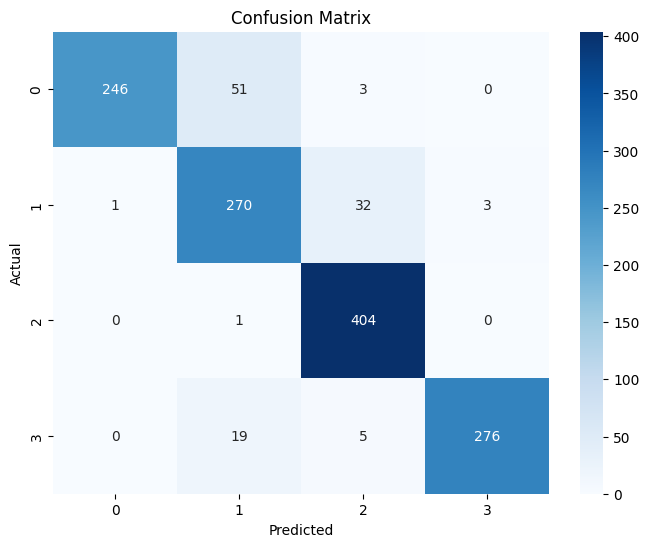

In [5]:
test_images = open_images(test_paths, num_augmentations=2)  # Generate only one augmented image per original image
test_loss, test_accuracy = model.evaluate(test_images, test_labels_encoded)
print("Test Accuracy:", test_accuracy)

# Classification report and confusion matrix
y_pred = np.argmax(model.predict(test_images), axis=-1)
print(classification_report(test_labels_encoded, y_pred))

cm = confusion_matrix(test_labels_encoded, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## USING MOBILENET

In [6]:
import numpy as np
import os
import random
from PIL import Image, ImageEnhance
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# Define constants
IMAGE_SIZE = 128
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'

# Data preparation
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(train_dir + label):
        train_paths.append(train_dir + label + '/' + image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(test_dir + label):
        test_paths.append(test_dir + label + '/' + image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

# Data Augmentation
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0
    return image

def open_images(paths, num_augmentations=2):
    images = []
    for path in paths:
        original_image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        original_image = np.array(original_image) / 255.0
        images.append(original_image)
        for _ in range(num_augmentations - 1):
            augmented_image = augment_image(original_image)
            images.append(augmented_image)
    return np.array(images)

# Model definition
def create_mobilenet_model(input_shape, num_classes):
    base_model = keras.applications.MobileNetV2(include_top=False, input_shape=input_shape)
    base_model.trainable = True
    model = keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

model = create_mobilenet_model((IMAGE_SIZE, IMAGE_SIZE, 3), len(set(train_labels)))

# Model compilation with learning rate scheduling
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

from sklearn.preprocessing import LabelEncoder

# Label encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Model training
batch_size = 32
epochs = 30

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
history = model.fit(
    open_images(train_paths),
    np.repeat(train_labels_encoded, 2),  # Repeat labels for each augmented image
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 60s 34ms/step - accuracy: 0.5280 - loss: 1.0909
Epoch 2/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.6005 - loss: 0.8365
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.6075 - loss: 0.7985
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.6214 - loss: 0.7627
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.6279 - loss: 0.7407
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.6303 - loss: 0.7429
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.6392 - loss: 0.7204
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.6218 - loss: 0.7413
Epoch 9/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.6332 - loss: 0.7285
Epoch 10/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.6325 - loss: 0.7266
Epoch 11/30
 45/357 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.6092 - loss: 0.7474

KeyboardInterrupt: 

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.6484 - loss: 1.7067
Test Accuracy: 0.6567505598068237
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step
              precision    recall  f1-score   support

           0       0.41      1.00      0.58       300
           1       0.99      0.56      0.71       306
           2       1.00      0.55      0.70       405
           3       0.90      0.56      0.69       300

    accuracy                           0.66      1311
   macro avg       0.82      0.67      0.67      1311
weighted avg       0.84      0.66      0.68      1311



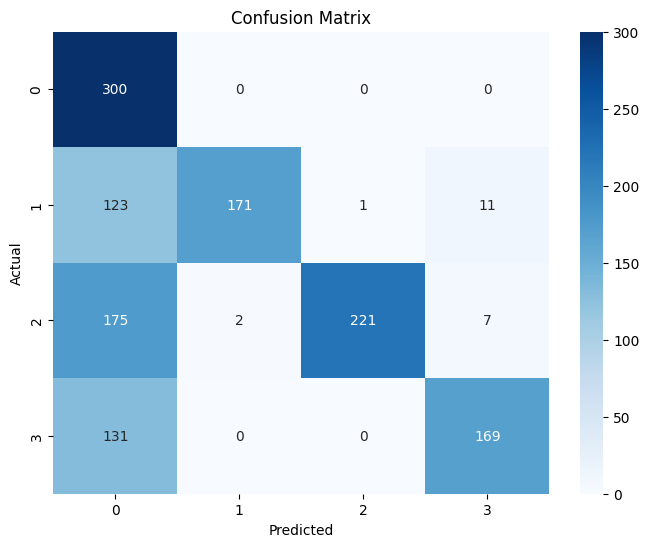

In [8]:
test_images = open_images(test_paths, num_augmentations=1)  # Generate only one augmented image per original image
test_loss, test_accuracy = model.evaluate(test_images, test_labels_encoded)
print("Test Accuracy:", test_accuracy)

# Classification report and confusion matrix
y_pred = np.argmax(model.predict(test_images), axis=-1)
print(classification_report(test_labels_encoded, y_pred))

cm = confusion_matrix(test_labels_encoded, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [9]:
import numpy as np
import os
import random
from PIL import Image, ImageEnhance
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# Define constants
IMAGE_SIZE = 128
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'

# Data preparation
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(train_dir + label):
        train_paths.append(train_dir + label + '/' + image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(test_dir + label):
        test_paths.append(test_dir + label + '/' + image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

# Data Augmentation
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0
    return image

def open_images(paths, num_augmentations=2):
    images = []
    for path in paths:
        original_image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        original_image = np.array(original_image) / 255.0
        images.append(original_image)
        for _ in range(num_augmentations - 1):
            augmented_image = augment_image(original_image)
            images.append(augmented_image)
    return np.array(images)

# Model definition
def create_efficientnet_model(input_shape, num_classes):
    base_model = keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape)
    base_model.trainable = True
    model = keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

model = create_efficientnet_model((IMAGE_SIZE, IMAGE_SIZE, 3), len(set(train_labels)))

# Model compilation with learning rate scheduling
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

from sklearn.preprocessing import LabelEncoder

# Label encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Model training
batch_size = 32
epochs = 30

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
history = model.fit(
    open_images(train_paths),
    np.repeat(train_labels_encoded, 2),  # Repeat labels for each augmented image
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 101s 52ms/step - accuracy: 0.5221 - loss: 1.0384
Epoch 2/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.5912 - loss: 0.8174
Epoch 3/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.5977 - loss: 0.7784
Epoch 4/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.6085 - loss: 0.7771
Epoch 5/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.6219 - loss: 0.7333
Epoch 6/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.6278 - loss: 0.7377
Epoch 7/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.6338 - loss: 0.7150
Epoch 8/30
357/357 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.6171 - loss: 0.7296
Epoch 9/30
161/357 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.6451 - loss: 0.7098

KeyboardInterrupt: 

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9861 - loss: 0.0413
Test Accuracy: 0.9855072498321533
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       300
           1       0.97      0.97      0.97       306
           2       1.00      1.00      1.00       405
           3       0.98      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.99      0.99      0.99      1311



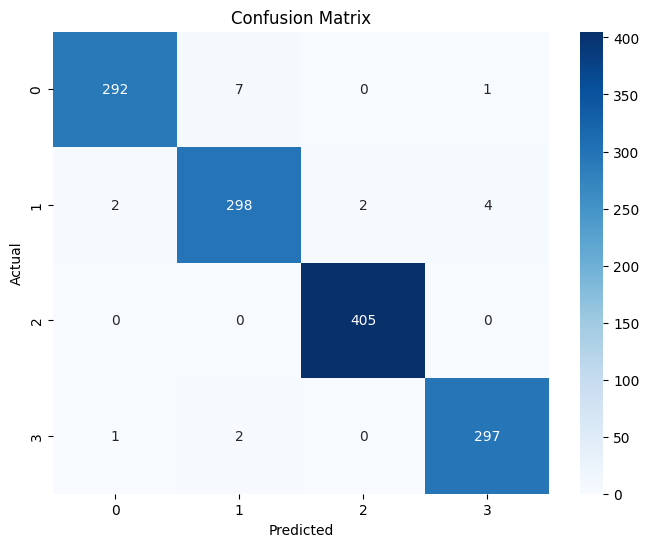

In [11]:
test_images = open_images(test_paths, num_augmentations=1)  # Generate only one augmented image per original image
test_loss, test_accuracy = model.evaluate(test_images, test_labels_encoded)
print("Test Accuracy:", test_accuracy)

# Classification report and confusion matrix
y_pred = np.argmax(model.predict(test_images), axis=-1)
print(classification_report(test_labels_encoded, y_pred))

cm = confusion_matrix(test_labels_encoded, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# EFFICIENTNET MODEL GAVE 98.5% ACCURACY OVERALL 

In [12]:
import numpy as np
import os
import random
from PIL import Image, ImageEnhance
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

# Define constants
IMAGE_SIZE = 128
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training/'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing/'

# Data preparation
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(train_dir + label):
        train_paths.append(train_dir + label + '/' + image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(test_dir + label):
        test_paths.append(test_dir + label + '/' + image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

# Data Augmentation
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = np.array(image) / 255.0
    return image

def open_images(paths, num_augmentations=2):
    images = []
    for path in paths:
        original_image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        original_image = np.array(original_image) / 255.0
        images.append(original_image)
        for _ in range(num_augmentations - 1):
            augmented_image = augment_image(original_image)
            images.append(augmented_image)
    return np.array(images)

# Model definition
def create_custom_model(input_shape, num_classes):
    model = keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

model = create_custom_model((IMAGE_SIZE, IMAGE_SIZE, 3), len(set(train_labels)))

# Model compilation with learning rate scheduling
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

from sklearn.preprocessing import LabelEncoder

# Label encoding
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Model training
batch_size = 32
epochs = 30

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [ ]:
history = model.fit(
    open_images(train_paths),
    np.repeat(train_labels_encoded, 2),  # Repeat labels for each augmented image
    epochs=epochs,
    batch_size=batch_size
)

In [ ]:
test_images = open_images(test_paths, num_augmentations=1)  # Generate only one augmented image per original image
test_loss, test_accuracy = model.evaluate(test_images, test_labels_encoded)
print("Test Accuracy:", test_accuracy)

# Classification report and confusion matrix
y_pred = np.argmax(model.predict(test_images), axis=-1)
print(classification_report(test_labels_encoded, y_pred))

cm = confusion_matrix(test_labels_encoded, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()